In [1]:
import keras
from keras.datasets import cifar10
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os
import tensorflow as tf
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

/Users/ianlee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
print('model loaded')

# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    big_X_train = np.array([scipy.misc.imresize(X_train[i], (139, 139, 3)) 
                            for i in range(0, len(X_train))]).astype('float32')
    inception_input_train = preprocess_input(big_X_train)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
    
print('bottleneck features saved (train)')

model loaded
bottleneck features file not detected (train)
calculating now ...


NameError: name 'X_train' is not defined

In [23]:
# obtain bottleneck features (test)
if os.path.exists('inception_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_X_test = np.array([scipy.misc.imresize(X_test[i], (139, 139, 3)) 
                       for i in range(0, len(X_test))]).astype('float32')
    inception_input_test = preprocess_input(big_X_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


In [41]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(features, y_train, batch_size=50, epochs=50,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 1, 1, 32)          589856    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 589,955
Trainable params: 589,955
Non-trainable params: 0
_________________________________________________________________
Train on 15425 samples, validate on 3857 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 5.85130, saving model to model.be

In [42]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.best.hdf5')

# evaluate test accuracy
score = model.evaluate(features_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 74.9430%


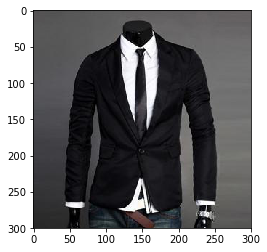

In [10]:
img=plt.imread('img/Single-Button_Blazer/img_00000001.jpg')
imgplot = plt.imshow(img)

In [17]:
img2category = open('list_category_img.txt', 'r') 
category2type = open('list_category_cloth.txt', 'r')
img2category_lines = img2category.readlines()
category2type_lines = category2type.readlines()


labels=[]
imgs=[]
step = 10 # we get 289000/step images
category_count = {}

for i, line in enumerate(img2category_lines[2:]):
    if i % step == 0:
        img_name = line.split()[0]
        label = int(line.split()[1]) - 1 # let's make it 0-indexed
        labels.append(label)
        if label not in category_count:
            category_count[label] = 0
        category_count[label] += 1
        
        img = plt.imread(img_name)
        imgs.append(scipy.misc.imresize(img, (32,32,3)))

imgs_temp = np.asarray(imgs)
labels_temp = np.asarray(labels)
    
categories = [] #category #49 and #50 are not found in the dataset. Doesn't matter
category2type = {} 
    
for i, line in enumerate(category2type_lines[2:]):
    category = line.split()[0]
    category_type = int(line.split()[1])
    categories.append(category)
    category2type[i] = category_type
    

In [18]:
imgs = imgs_temp
labels = np.array([category2type[label] for label in labels_temp])

In [19]:
labels

array([1, 1, 1, ..., 3, 3, 3])

In [20]:
print(len(categories))
print(categories)
print(len(labels))
print(category_count)
print(category2type)

50
['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']
28923
{2: 2455, 1: 753, 4: 32, 3: 30, 0: 16, 17: 3682, 16: 1556, 18: 1003, 15: 1315, 6: 33, 9: 405, 5: 1325, 10: 1049, 8: 69, 14: 77, 11: 77, 19: 16, 12: 66, 13: 10, 7: 2, 32: 1469, 31: 1979, 25: 709, 28: 441, 33: 300, 26: 60, 23: 168, 34: 105, 29: 503, 22: 49, 21: 53, 35: 39, 30: 4, 24: 5, 27: 5, 20: 8, 40: 7232, 47: 729, 38: 213, 43: 227, 41: 614, 46: 14, 36: 5, 42: 12, 39: 2, 45: 7}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12:

In [21]:
order = np.arange(len(labels))
np.random.shuffle(order)

shuffled_imgs = imgs[order]
shuffled_labels = labels[order]

length = shuffled_labels.shape[0]

X_train = shuffled_imgs[:length*2//3]
y_train = shuffled_labels[:length*2//3]

X_val = shuffled_imgs[length*2//3:length*5//6]
y_val = shuffled_labels[length*2//3:length*5//6]

X_test = shuffled_imgs[length*5//6:]
y_test = shuffled_labels[length*5//6:]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (19282, 32, 32, 3)
Train labels shape:  (19282,)
Validation data shape:  (4820, 32, 32, 3)
Validation labels shape:  (4820,)
Test data shape:  (4821, 32, 32, 3)
Test labels shape:  (4821,)


In [24]:
np.save("X_train", X_train)
np.save("y_train", y_train)
np.save("X_val", X_val)
np.save("y_val", y_val)
np.save("X_test", X_test)
np.save("y_test", y_test)

In [27]:
# load the data
(x_train_temp, y_train_temp), (x_test_temp, y_test_temp) = cifar10.load_data()
y_train_temp = np.squeeze(y_train_temp)
print('data loaded')

data loaded


In [28]:
y_train_temp.shape

(50000,)

In [29]:
y_train_temp

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [36]:
np.max(y_train)

3

In [30]:
y_train.shape

(19282,)

In [33]:
from keras.utils import np_utils

# one-hot encode the labels
y_train_temp = np_utils.to_categorical(y_train_temp, 10)
y_test_temp = np_utils.to_categorical(y_test_temp, 10)

In [38]:
y_train = np_utils.to_categorical(y_train-1, 3)
y_test = np_utils.to_categorical(y_test-1, 3)